# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt

import re
import nltk
from sklearn.model_selection import train_test_split

# Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

path1='/content/drive/MyDrive/Clean_text.txt'
path2='/content/drive/MyDrive/combined_text.txt'
path3='/content/drive/MyDrive/cleaned_output.txt'

In [4]:
# opening files from given paths
file1 = open(path1, 'rb').read().decode(encoding='utf-8')
file2 = open(path2, 'rb').read().decode(encoding='utf-8')
file3 = open(path3, 'rb').read().decode(encoding='utf-8')

# Combining Text files

In [5]:
combined_file='final_combined_text.txt'

In [6]:
import shutil

def merge_files_with_shutil(file1, file2,file3, merged_file):
    with open(merged_file, 'wb') as outfile:
        for filename in [file1, file2,file3]:
            with open(filename, 'rb') as infile:
                shutil.copyfileobj(infile, outfile)


merge_files_with_shutil(path1, path2,path3, combined_file)

In [7]:
combined_text= open(combined_file, 'rb').read().decode(encoding='utf-8')

# Punctuation removing and lower casing the text

In [8]:
import string
combined_text=combined_text.strip(string.punctuation)

In [9]:
combined_text=combined_text.lower()

In [10]:
combined_text

'title agriculture census pakistan bureau of statistics agriculture census pakistan bureau of statistics skip to main content search search main navigation home about us contacts tenders jobs related links data request nsdp faqs disability statistics pbs datafest 2024 home introduction agriculture census organization aco was established in 1958 as an attached department of the then ministry of agriculture under the legal cover of agriculture census act 1958. immediately after its inception, aco conducted agriculture census of 1960 to fulfill national and international requirements of data on agriculture. later on, this organization conducted a surveycumcensus under the recommendation of the farm mechanization committee, government of pakistan, in 1968 and an agriculture census in 1972 which was actually due in 1970. two years delay in the conduct of agriculturel census was on account of disturbed political environment in the country and war with india. subsequently, aco conducted lives

In [11]:
import re

# Define the characters to remove
pattern = r"[\"\r'(),\-\.]"

# Apply the regex to clean the text
cleaned_text = re.sub(pattern, '', combined_text)

print("Cleaned Text:")
cleaned_text

Cleaned Text:


'title agriculture census pakistan bureau of statistics agriculture census pakistan bureau of statistics skip to main content search search main navigation home about us contacts tenders jobs related links data request nsdp faqs disability statistics pbs datafest 2024 home introduction agriculture census organization aco was established in 1958 as an attached department of the then ministry of agriculture under the legal cover of agriculture census act 1958 immediately after its inception aco conducted agriculture census of 1960 to fulfill national and international requirements of data on agriculture later on this organization conducted a surveycumcensus under the recommendation of the farm mechanization committee government of pakistan in 1968 and an agriculture census in 1972 which was actually due in 1970 two years delay in the conduct of agriculturel census was on account of disturbed political environment in the country and war with india subsequently aco conducted livestock cens

# Embedding Files loading

In [12]:
# Function to load embeddings from multiple files
def load_embeddings(file_paths):
    embedding_index = {}
    for glove_file_path in file_paths:
        with open(glove_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embedding_index[word] = coefs
        print(f"Loaded GloVe embeddings from {glove_file_path}")
    return embedding_index

In [13]:
file_paths=['/content/drive/MyDrive/embed_shahab.txt', '/content/drive/MyDrive/word_embeddings.txt', '/content/drive/MyDrive/word_embeddings_file.txt']
embedding_index = load_embeddings(file_paths)


Loaded GloVe embeddings from /content/drive/MyDrive/embed_shahab.txt
Loaded GloVe embeddings from /content/drive/MyDrive/word_embeddings.txt
Loaded GloVe embeddings from /content/drive/MyDrive/word_embeddings_file.txt


# Tokenization

In [14]:
 #Tokenize the text into words
words = cleaned_text.split()

## Word embedding

In [15]:
import numpy as np


# Function to retrieve embeddings for words using the GloVe embedding index
def get_word_embeddings(words, embedding_index, embedding_dim=30):

    embeddings = []
    for word in words:
        if word in embedding_index:
            embeddings.append(embedding_index[word])
        else:
            # Handle unknown words with a zero vector
            embeddings.append(np.zeros(embedding_dim))
    return np.array(embeddings)

# Define the embedding dimension
embedding_dim = 30

# Get embeddings for the words
encoded_words = get_word_embeddings(words, embedding_index, embedding_dim)

# Display the shape of encoded data
print("Shape of encoded words:", encoded_words.shape)

Shape of encoded words: (46372, 30)


## Creating input and output sequences

In [16]:
# Define sequence length
seq_length = 10  # Number of words to use as context for prediction

# Prepare input-output sequences
input_sequences = []
output_sequences = []

for i in range(len(encoded_words) - seq_length):
    input_sequences.append(encoded_words[i:i+seq_length])
    output_sequences.append(encoded_words[i+seq_length])

input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

print("Shape of input sequences:", input_sequences.shape)
print("Shape of output sequences:", output_sequences.shape)

Shape of input sequences: (46362, 10, 30)
Shape of output sequences: (46362, 30)


## Splitting dataset

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_sequences, output_sequences, test_size=0.2, random_state=42
)

In [18]:

print("Shape of training input sequences:", X_train.shape)
print("Shape of training output sequences:", y_train.shape)
print("Shape of testing input sequences:", X_test.shape)
print("Shape of testing output sequences:", y_test.shape)

Shape of training input sequences: (37089, 10, 30)
Shape of training output sequences: (37089, 30)
Shape of testing input sequences: (9273, 10, 30)
Shape of testing output sequences: (9273, 30)


# Model Building

In [19]:
# Training the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define the RNN model
model = Sequential([
    LSTM(512, input_shape=(seq_length, encoded_words.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(512),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(encoded_words.shape[1])  # Output size matches the word embedding dimensions
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 512)             │       1,112,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           7,710 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,350,302 (12.78 MB)

 Trainable params: 3,350,302 (12.78 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [20]:
# Train the model using the training set
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0705 - mse: 0.0705 - val_loss: 0.0640 - val_mse: 0.0640
Epoch 2/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0605 - mse: 0.0605 - val_loss: 0.0533 - val_mse: 0.0533
Epoch 3/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 4/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0461 - val_mse: 0.0461
Epoch 5/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0414 - val_mse: 0.0414
Epoch 6/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0412 - mse: 0.0412 - val_loss: 0.0386 - val_mse: 0.0386
Epoch 7/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 8/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 9/10
580/580 ━━━━━━━━━━━━━━━━━━━━ 10s

# Generating text from trained model

In [21]:
def generate_text(model, start_words, gen_length=10, embedding_index=None, embedding_dim=300):

    if embedding_index is None:
        raise ValueError("embedding_index cannot be None. Please provide thE embedding index.")

    # Encode the starting words using GloVe embeddings
    def get_embedding(word):
        return embedding_index.get(word, np.zeros(embedding_dim))

    words = start_words.split()
    input_eval = np.array([get_embedding(word) for word in words])
    input_eval = np.expand_dims(input_eval, axis=0)  # Add batch dimension

    generated_text = start_words

    for _ in range(gen_length):
        # Predict the next word embedding
        predictions = model.predict(input_eval)
        predicted_word_embedding = predictions[0]  # Extract the predicted embedding

        # Find the closest word in the dataset based on the predicted embedding
        word_embeddings = np.array([get_embedding(word) for word in words])
        distances = np.linalg.norm(word_embeddings - predicted_word_embedding, axis=1)
        closest_word_idx = np.argmin(distances)
        next_word = words[closest_word_idx]

        # Append the word to the generated text
        generated_text += " " + next_word

        # Prepare the input for the next iteration
        next_word_embedding = np.expand_dims(get_embedding(next_word), axis=0)
        input_eval = np.append(input_eval[:, 1:, :], next_word_embedding[:, None, :], axis=1)

    return generated_text

In [22]:
# Assume you have a trained model and a GloVe embedding index
generated_text = generate_text(
    model=model,
    start_words="cover of agriculture",
    gen_length=10,
    embedding_index=embedding_index,
    embedding_dim=30
)

print("Generated text:", generated_text)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Generated text: cover of agriculture agriculture agriculture agriculture agriculture agriculture agriculture agriculture agriculture agriculture agriculture


# model saving

In [23]:
# Save the model checkpoint
model.save('model1_checkpoint.h5')

# Train and Validation Loss plot

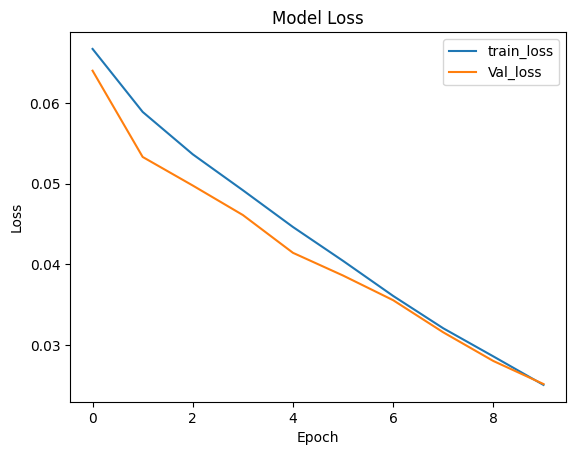

In [24]:
# Save the training and validation loss images
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model1_loss.png')
plt.show()

In [25]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=466b83c4e41b6711b992548e81f53579feb000a2a6ed978b445de858e8493092
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


# Model Evaluation

In [26]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Generate text and evaluate against a reference text
def evaluate_model(model, seed_text, reference_text, embedding_index, embedding_dim, gen_length=10):

    # Generate text using the model
    generated_text = generate_text(model, seed_text, gen_length, embedding_index, embedding_dim)

    # Tokenize texts into words
    generated_tokens = generated_text.split()
    reference_tokens = reference_text.split()

    print("Generated Tokens:", generated_tokens[:20])  # Display first 20 tokens for reference
    print("Reference Tokens:", reference_tokens[:20])  # Display first 20 tokens for reference

    # Calculate BLEU Score
    bleu_score = sentence_bleu([reference_tokens], generated_tokens)
    print(f"BLEU Score: {bleu_score:.4f}")

    # Calculate ROUGE Scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_text, generated_text)

    print("ROUGE Scores:")
    for metric, score in rouge_scores.items():
        print(f"{metric}: Precision: {score.precision:.4f}, Recall: {score.recall:.4f}, F1: {score.fmeasure:.4f}")

# Example usage for evaluation
seed_text = "pakistan bureau of statistics"
reference_text = "Pakistan Bureau of Statistics is a government organization responsible for conducting and analyzing various statistical data."

# Ensure embedding_index and embedding_dim are defined before calling the function
evaluate_model(model, seed_text, reference_text, embedding_index, 30, gen_length=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_